# Install Libs

In [1]:
dry_run = False
!pip install ../input/kornia-loftr/kornia-0.6.4-py2.py3-none-any.whl
!pip install ../input/kornia-loftr/kornia_moons-0.1.9-py3-none-any.whl
!pip install ../input/imc2022-submodules/e2cnn-0.2.1-py3-none-any.whl
!pip install ../input/imc2022-submodules/einops-0.4.1-py3-none-any.whl

Processing /kaggle/input/kornia-loftr/kornia-0.6.4-py2.py3-none-any.whl
  Attempting uninstall: kornia
    Found existing installation: kornia 0.5.8
    Uninstalling kornia-0.5.8:
      Successfully uninstalled kornia-0.5.8
Processing /kaggle/input/kornia-loftr/kornia_moons-0.1.9-py3-none-any.whl
Processing /kaggle/input/imc2022-submodules/e2cnn-0.2.1-py3-none-any.whl
Processing /kaggle/input/imc2022-submodules/einops-0.4.1-py3-none-any.whl


# Import dependencies

In [2]:
import cv2
import kornia as K
import os
import numpy as np
import pandas as pd
import torch

import warnings
warnings.simplefilter('ignore', UserWarning)

# Preprocess

In [3]:
MASK_RATIO_VERTICAL = 0.1 # for vertical(portrait) photos
MASK_RATIO_HORIZONTAL = 0.05 # for horizontal(landscape) photos

def bottom_mask(image):

    height, width = image.shape[:2]
    mask = np.ones((height, width), dtype=np.uint8)
    through_mask = mask

    # add bottom mask
    if height >= width:
        # vertical
        cv2.rectangle(mask, pt1=(0, int(height*(1-MASK_RATIO_VERTICAL))), pt2=(width, height), color=(0), thickness=-1)
    else:
        # horizontal
        cv2.rectangle(mask, pt1=(0, int(height*(1-MASK_RATIO_HORIZONTAL))), pt2=(width, height), color=(0), thickness=-1)

    return mask, through_mask

def crop_image(img, rect):

    xmin, ymin, xmax, ymax = rect
    xmin = max(0, int(xmin*img.shape[1] - 0.5))
    ymin = max(0, int(ymin*img.shape[0] - 0.5))
    xmax = min(img.shape[1], int(xmax*img.shape[1] + 0.5))
    ymax = min(img.shape[0], int(ymax*img.shape[0] + 0.5))

    return img[ymin:ymax, xmin:xmax], (xmin, ymin, xmax, ymax)

# Image matching

## ROI estimation (DKM model)

Deep Kernelized Dense Geometric Matching

https://arxiv.org/abs/2202.00667

https://github.com/Parskatt/DKM

In [4]:
from PIL import Image
import shutil
import sys
sys.path.append('../input/imc2022-submodules/DKM')
from dkm import DKM

def load_model_DKM(ckpt_path, working_dir):

    checkpoints_path = os.path.join(working_dir, "checkpoints")
    if not os.path.exists(checkpoints_path):
        os.makedirs(checkpoints_path)
    if not os.path.exists(os.path.join(checkpoints_path, "dkm_mega.pth")):
        shutil.copyfile(
            os.path.join(ckpt_path, "dkm_mega.pth"),
            os.path.join(checkpoints_path, "dkm_mega.pth"))

    torch.hub.set_dir(working_dir)
    model = DKM(pretrained=True, version="mega")
    return model

def convert_DKM_image(img, lrflip=False, ulflip=False):

    # flip
    if lrflip:
        img = cv2.flip(img, 1)
    if ulflip:
        img = cv2.flip(img, 0)

    # convert
    img = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

    return img

def expand_rect(rect, scale):

    x_center = (rect[0] + rect[2])/2
    y_center = (rect[1] + rect[3])/2
    w = (rect[2] - rect[0]) / 2
    h = (rect[3] - rect[1]) / 2
    w *= scale
    h *= scale
    rect = [max(0, x_center - w), max(0, y_center - h), min(1, x_center + w), min(1, y_center + h)]

    return rect

def matching_DKM(input_image_1, input_image_2, DKM_param):

    matcher = DKM_param["model"]
    scale = DKM_param["scale"]
    sample_num = DKM_param["sample_num"]

    _image_1 = convert_DKM_image(input_image_1)
    _image_2 = convert_DKM_image(input_image_2)

    # step1: dense matching
    dense_matches, dense_certainty = matcher.match(_image_1, _image_2)
    dense_certainty = dense_certainty.sqrt()

    matches, confidence = (
        dense_matches.reshape(-1, 4).cpu().numpy(),
        dense_certainty.reshape(-1).cpu().numpy(),
    )
    mkpts1 = matches[:, :2]
    mkpts2 = matches[:, 2:]

    # step2: adaptive thresholding
    relative_confidence = confidence/confidence.max()
    relative_confidence_threshold = (cv2.threshold((relative_confidence*255.0).astype(np.uint8), 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)[0]) / 255.0

    idx = relative_confidence > relative_confidence_threshold
    mkpts1 = mkpts1[idx]
    mkpts2 = mkpts2[idx]
    confidence = confidence[idx]

    # coordinate transformation
    # Note that matches are produced in the normalized grid [-1, 1] x [-1, 1]
    mkpts1[:, 0] = ((mkpts1[:, 0] + 1)/2)
    mkpts1[:, 1] = ((mkpts1[:, 1] + 1)/2)
    mkpts2[:, 0] = ((mkpts2[:, 0] + 1)/2)
    mkpts2[:, 1] = ((mkpts2[:, 1] + 1)/2)

    # step3: ROI estimation
    img_pair_rect = {
        "image1": [
            np.min(mkpts1[:, 0]), np.min(mkpts1[:, 1]),
            np.max(mkpts1[:, 0]), np.max(mkpts1[:, 1])],
        "image2": [
            np.min(mkpts2[:, 0]), np.min(mkpts2[:, 1]),
            np.max(mkpts2[:, 0]), np.max(mkpts2[:, 1])],
    }

    img_pair_rect["image1"] = expand_rect(img_pair_rect["image1"], scale)
    img_pair_rect["image2"] = expand_rect(img_pair_rect["image2"], scale)

    # step4: sparse matching
    sparse_matches, sparse_certainty = matcher.sample(
        dense_matches, dense_certainty,
        num = sample_num,
        relative_confidence_threshold = relative_confidence_threshold)

    mkpts1 = sparse_matches[:, :2]
    mkpts2 = sparse_matches[:, 2:]

    h, w = input_image_1.shape[:2]
    mkpts1[:, 0] = ((mkpts1[:, 0] + 1)/2) * w
    mkpts1[:, 1] = ((mkpts1[:, 1] + 1)/2) * h

    h, w = input_image_2.shape[:2]
    mkpts2[:, 0] = ((mkpts2[:, 0] + 1)/2) * w
    mkpts2[:, 1] = ((mkpts2[:, 1] + 1)/2) * h

    confidence = sparse_certainty.reshape(-1)

    return img_pair_rect, mkpts1, mkpts2, confidence

## Feature matching (LoFTR model)

LoFTR: Detector-Free Local Feature Matching with Transformers

https://arxiv.org/abs/2104.00680

https://github.com/zju3dv/LoFTR

In [5]:
import kornia.feature as KF
def load_model_LoFTR(ckpt_path, device):
    model = KF.LoFTR(pretrained=None)
    model.load_state_dict(torch.load(ckpt_path)["state_dict"])
    model = model.to(device).eval()
    return model

def convert_LoFTR_image(img, img_size=-1, lrflip=False, ulflip=False):

    # resize
    if img_size > 0:
        height, width = img.shape[:2]
        scale = img_size / max(width, height)
        w = int(width * scale + 0.5)
        h = int(height * scale + 0.5)
        if scale > 1.0:
            interpolation=cv2.INTER_CUBIC
        else:
            interpolation=cv2.INTER_AREA
        img = cv2.resize(img, (w, h), interpolation=interpolation)
    else:
        scale = 1.0

    # crop
    height, width = img.shape[:2]
    img = img[:height//8*8, :width//8*8]

    # flip
    if lrflip:
        img = cv2.flip(img, 1)
    if ulflip:
        img = cv2.flip(img, 0)

    # convert
    img = K.image_to_tensor(img, False).float() / 255.
    img = K.color.bgr_to_rgb(img)

    return img, scale

def matching_loftr(input_image_1, input_image_2, mask_1, mask_2, LoFTR_param):

    img_size = LoFTR_param["img_size"]
    matcher = LoFTR_param["model"]
    device = LoFTR_param["device"]

    image_1_list = []
    image_2_list = []
    scale_1 = 1
    scale_2 = 1
    for lrflip in [False, True]:
        for ulflip in [False]:
            _image_1, _scale_1 = convert_LoFTR_image(input_image_1, img_size=img_size, lrflip=lrflip, ulflip=ulflip)
            _image_2, _scale_2 = convert_LoFTR_image(input_image_2, img_size=img_size, lrflip=lrflip, ulflip=ulflip)
            image_1_list.append(_image_1)
            image_2_list.append(_image_2)
            scale_1 = _scale_1
            scale_2 = _scale_2

    image_1 = torch.cat(image_1_list, dim=0)
    image_2 = torch.cat(image_2_list, dim=0)

    input_dict = {"image0": K.color.rgb_to_grayscale(image_1).to(device),
                  "image1": K.color.rgb_to_grayscale(image_2).to(device),
                  "mask0": K.utils.image_to_tensor(mask_1).to(device),
                  "mask1": K.utils.image_to_tensor(mask_2).to(device)}

    with torch.no_grad():
        correspondences = matcher(input_dict)

    mkpts1 = correspondences["keypoints0"].cpu().numpy()
    mkpts2 = correspondences["keypoints1"].cpu().numpy()
    confidence = correspondences["confidence"].cpu().numpy()
    batch_indexes = correspondences["batch_indexes"].cpu().numpy()

    mkpts1_all = []
    mkpts2_all = []
    confidence_all = []
    batch_id = 0
    for lrflip in [False, True]:
        for ulflip in [False]:

            idx = batch_indexes == batch_id
            _mkpts1 = mkpts1[idx]
            _mkpts2 = mkpts2[idx]
            _confidence = confidence[idx]
            if lrflip:
                for i in range(len(_mkpts1)):
                    _mkpts1[i][0] = image_1.shape[3] - _mkpts1[i][0]
                    _mkpts2[i][0] = image_2.shape[3] - _mkpts2[i][0]
            if ulflip:
                for i in range(len(_mkpts1)):
                    _mkpts1[i][1] = image_1.shape[2] - _mkpts1[i][1]
                    _mkpts2[i][1] = image_2.shape[2] - _mkpts2[i][1]

            mkpts1_all.append(_mkpts1)
            mkpts2_all.append(_mkpts2)
            confidence_all.append(_confidence)

            batch_id += 1

    mkpts1 = np.concatenate(mkpts1_all, axis=0)
    mkpts2 = np.concatenate(mkpts2_all, axis=0)
    confidence = np.concatenate(confidence_all, axis=0)

    mkpts1 /= scale_1
    mkpts2 /= scale_2

    return mkpts1, mkpts2, confidence

## Feature matching (SE2-LoFTR model)

A case for using rotation invariant features in state of the art feature matchers

https://arxiv.org/abs/2204.10144

https://github.com/georg-bn/se2-loftr

In [6]:
import sys
sys.path.append("../input/imc2022-submodules/se2-loftr")
from copy import deepcopy
from src.loftr import LoFTR, default_cfg

def load_model_SE2LoFTR(ckpt_path, device):

    _default_cfg = deepcopy(default_cfg)
    _default_cfg['coarse']['temp_bug_fix'] = True
    _default_cfg['backbone_type'] = 'E2ResNetFPN'
    _default_cfg['resnetfpn']['nbr_rotations'] = 4
    _default_cfg['resnetfpn']['e2_same_nbr_filters'] = False

    model = LoFTR(config=_default_cfg)
    model.load_state_dict(torch.load(ckpt_path, map_location=device)['state_dict'])
    model = model.to(device).eval()

    return model

def matching_se2loftr(input_image_1, input_image_2, SE2LoFTR_param):

    img_size = SE2LoFTR_param["img_size"]
    matcher = SE2LoFTR_param["model"]
    device = SE2LoFTR_param["device"]

    image_1_list = []
    image_2_list = []
    scale_1 = 1
    scale_2 = 1
    for lrflip in [False, True]:
        for ulflip in [False]:
            _image_1, _scale_1 = convert_LoFTR_image(input_image_1, img_size=img_size, lrflip=lrflip, ulflip=ulflip)
            _image_2, _scale_2 = convert_LoFTR_image(input_image_2, img_size=img_size, lrflip=lrflip, ulflip=ulflip)
            image_1_list.append(_image_1)
            image_2_list.append(_image_2)
            scale_1 = _scale_1
            scale_2 = _scale_2

    image_1 = torch.cat(image_1_list, dim=0)
    image_2 = torch.cat(image_2_list, dim=0)

    input_dict = {"image0": K.color.rgb_to_grayscale(image_1).to(device),
                  "image1": K.color.rgb_to_grayscale(image_2).to(device)}

    with torch.no_grad():
        matcher(input_dict)

    mkpts1_all = []
    mkpts2_all = []
    confidence_all = []
    batch_id = 0
    for lrflip in [False, True]:
        for ulflip in [False]:

            # https://github.com/zju3dv/LoFTR/issues/58
            _mkpts1 = input_dict["mkpts0_f"][input_dict['m_bids'] == batch_id].cpu().numpy()
            _mkpts2 = input_dict["mkpts1_f"][input_dict['m_bids'] == batch_id].cpu().numpy()
            _confidence = input_dict["mconf"][input_dict['m_bids'] == batch_id].cpu().numpy()
            if lrflip:
                for i in range(len(_mkpts1)):
                    _mkpts1[i][0] = image_1.shape[3] - _mkpts1[i][0]
                    _mkpts2[i][0] = image_2.shape[3] - _mkpts2[i][0]
            if ulflip:
                for i in range(len(_mkpts1)):
                    _mkpts1[i][1] = image_1.shape[2] - _mkpts1[i][1]
                    _mkpts2[i][1] = image_2.shape[2] - _mkpts2[i][1]

            mkpts1_all.append(_mkpts1)
            mkpts2_all.append(_mkpts2)
            confidence_all.append(_confidence)

            batch_id += 1

    mkpts1 = np.concatenate(mkpts1_all, axis=0)
    mkpts2 = np.concatenate(mkpts2_all, axis=0)
    confidence = np.concatenate(confidence_all, axis=0)

    mkpts1 /= scale_1
    mkpts2 /= scale_2

    return mkpts1, mkpts2, confidence

## Feature matching (SGMNet model)

Learning to Match Features with Seeded Graph Matching Network

https://arxiv.org/abs/2108.08771

https://github.com/vdvchen/SGMNet

In [7]:
import sys
import numpy as np
sys.path.append("../input/imc2022-submodules/SGMNet")
from components import load_component

def load_model_SGMNet(ckpt_path):

    extractor_cfg = {
        "name": "root",
        "num_kpt": 4000,
        "resize": [-1],
        "det_th": 0.00001,
    }
    extractor = load_component("extractor", extractor_cfg["name"], extractor_cfg)

    matcher_cfg = {
        "name": "SGM",
        "model_dir": ckpt_path,
        "seed_top_k": [256,256],
        "seed_radius_coe": 0.01,
        "net_channels": 128,
        "layer_num": 9,
        "head": 4,
        "seedlayer": [0,6],
        "use_mc_seeding": True,
        "use_score_encoding": False,
        "conf_bar": [1.11,0.1],
        "sink_iter": [10,100],
        "detach_iter": 1000000,
        "p_th": 0.2,
    }

    SGM_matcher = load_component("matcher", matcher_cfg["name"], matcher_cfg)

    model = {
        "extractor": extractor,
        "matcher": SGM_matcher,
    }

    return model

def extract_SGM(image1, image2, SGM_param):
    extractor = SGM_param["model"]["extractor"]

    size1, size2 = np.flip(np.asarray(image1.shape[:2])), np.flip(np.asarray(image2.shape[:2]))
    kpt1, desc1 = extractor.run(cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY))
    kpt2, desc2 = extractor.run(cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY))
    test_data = {"x1":kpt1, "x2":kpt2, "desc1":desc1, "desc2":desc2, "size1":size1, "size2":size2}

    return test_data

def matching_SGM(test_data, SGM_param):
    matcher = SGM_param["model"]["matcher"]

    mkpts0, mkpts1 = matcher.run(test_data)

    return mkpts0, mkpts1

# Postprocess

## NMS-based outlier pre-filtering

Efficient adaptive non-maximal suppression algorithms for homogeneous spatial keypoint distribution

https://www.researchgate.net/publication/323388062_Efficient_adaptive_non-maximal_suppression_algorithms_for_homogeneous_spatial_keypoint_distribution

https://github.com/BAILOOL/ANMS-Codes

In [8]:
import sys
sys.path.append("../input/imc2022-submodules/ANMS-Codes/Python")
from ssc import ssc

def nms_core(w, h, mkpts, confidence, num_ret_points, tolerance=0.1):

    keypoints = []
    for pt1, conf in zip(mkpts, confidence):
        keypoints.append(
            cv2.KeyPoint(x=pt1[1], y=pt1[0], size=1, angle=0, response=conf, octave=0, class_id=0)
        )

    # keypoints should be sorted by strength in descending order
    # before feeding to SSC to work correctly
    keypoints = sorted(keypoints, key=lambda x: x.response, reverse=True)

    selected_keypoints = ssc(keypoints, num_ret_points, tolerance, h, w)
    if len(selected_keypoints) > num_ret_points:
        selected_keypoints = np.random.choice(selected_keypoints, num_ret_points, replace=False)

    mkpts_list = mkpts.tolist()
    index_list = []
    for kp in selected_keypoints:
        x, y = kp.pt
        index_list.append(mkpts_list.index([y, x]))

    return index_list

In [9]:
def nms(image_1_width, image_1_height, mkpts1, mkpts2, confidence, num_ret_points):

    if num_ret_points < len(mkpts1):
        selected_index = nms_core(image_1_width, image_1_height, mkpts1, confidence, num_ret_points)
        mkpts1 = mkpts1[selected_index]
        mkpts2 = mkpts2[selected_index]
        confidence = confidence[selected_index]

    return mkpts1, mkpts2, confidence

def mkpts_filtering(mkpts1, mkpts2, confidence, param, image_1_width, image_1_height):

    # confidence_thr
    idx = confidence > param["conf_min_thr"]
    mkpts1 = mkpts1[idx]
    mkpts2 = mkpts2[idx]
    confidence = confidence[idx]

    # non-maximum suppression
    mkpts1, mkpts2, confidence = nms(
        image_1_width, image_1_height,
        mkpts1, mkpts2, confidence,
        param["nms_ret_points"])

    return mkpts1, mkpts2, confidence

# weighted random sampling
def points_sample(dense_matches_1, dense_matches_2, dense_confidence, num = 2000, relative_confidence_threshold = 0.0):
    matches_1 = dense_matches_1
    matches_2 = dense_matches_2
    confidence = dense_confidence
    relative_confidence = confidence/confidence.max()
    matches_1, matches_2, confidence = (
        matches_1[relative_confidence > relative_confidence_threshold],
        matches_2[relative_confidence > relative_confidence_threshold],
        confidence[relative_confidence > relative_confidence_threshold],
    )
    good_samples = np.random.choice(
        np.arange(len(matches_1)),
        size=min(num, len(confidence)),
        replace=False,
        p=confidence/np.sum(confidence),
    )
    return matches_1[good_samples], matches_2[good_samples], confidence[good_samples]

def matching_postprocess(args, params):

    LoFTR_param = params["LoFTR"]
    SE2LoFTR_param = params["SE2LoFTR"]
    DKM_param = params["DKM"]
    findFMat_param = params["findFMat"]

    image_1_width = args["image_1_width"]
    image_1_height = args["image_1_height"]
    DKM_result = args["DKM"]
    LoFTR_result = args["LoFTR"]
    LoFTR_NC_result = args["LoFTR_NC"]
    SE2LoFTR_result = args["SE2LoFTR"]
    SGM_result = args["SGMNet"]

    # LoFTR concat
    mkpts1_LoFTR = np.concatenate((LoFTR_result["mkpts1"], LoFTR_NC_result["mkpts1"]), axis=0)
    mkpts2_LoFTR = np.concatenate((LoFTR_result["mkpts2"], LoFTR_NC_result["mkpts2"]), axis=0)
    confidence_LoFTR = np.concatenate((LoFTR_result["confidence"], LoFTR_NC_result["confidence"]), axis=0)

    #------------------------------------------------
    # correspondence points filtering

    # LoFTR
    mkpts1_LoFTR, mkpts2_LoFTR, confidence_LoFTR = mkpts_filtering(
        mkpts1_LoFTR, mkpts2_LoFTR, confidence_LoFTR,
        LoFTR_param,
        image_1_width, image_1_height)

    # SE2-LoFTR
    mkpts1_SE2LoFTR, mkpts2_SE2LoFTR, confidence_SE2LoFTR = mkpts_filtering(
        SE2LoFTR_result["mkpts1"],
        SE2LoFTR_result["mkpts2"],
        SE2LoFTR_result["confidence"],
        SE2LoFTR_param,
        image_1_width, image_1_height)

    # correspondence points filtering
    #------------------------------------------------

    # concat
    mkpts1 = np.concatenate((mkpts1_LoFTR, mkpts1_SE2LoFTR), axis=0)
    mkpts2 = np.concatenate((mkpts2_LoFTR, mkpts2_SE2LoFTR), axis=0)
    confidence = np.concatenate((confidence_LoFTR, confidence_SE2LoFTR), axis=0)

    if SGM_result is not None:
        # SGMNet boosting
        mkpts1 = np.concatenate((mkpts1, SGM_result["mkpts1"]), axis=0)
        mkpts2 = np.concatenate((mkpts2, SGM_result["mkpts2"]), axis=0)
    else:
        # weighted random sampling
        mkpts1, mkpts2, _ = points_sample(
            mkpts1, mkpts2, confidence, num = findFMat_param["input_num"])

    # When only a few percent of the usual number of correspondence points are found.
    # Judging the scene to be extremely difficult to find sufficient correspondence points
    # with the usual approach, search for correspondence points with DKM alone, not with an ensemble.
    if len(mkpts1) < DKM_param["mkpts_num_thr"]:
        mkpts1, mkpts2, confidence = nms(
            image_1_width, image_1_height,
            DKM_result["mkpts1"],
            DKM_result["mkpts2"],
            DKM_result["confidence"],
            DKM_param["nms_ret_points"])

    return mkpts1, mkpts2

# Pipeline implementation

In [10]:
def preprocess(_args, params):

    SGM_param = params["SGMNet"]

    #----------------------
    # args_1
    # Load image
    if _args["args_1"] is None:
        result_1 = None
    else:
        args = _args["args_1"]
        image_dir = args["image_dir"]
        image_1_id = args["image_1_id"]
        image_2_id = args["image_2_id"]
        ext = args["ext"]

        # Load image
        image_1 = cv2.imread(os.path.join(image_dir, f"{image_1_id}.{ext}"))
        image_2 = cv2.imread(os.path.join(image_dir, f"{image_2_id}.{ext}"))
        image_1_height, image_1_width = image_1.shape[:2]

        # generate mask (bottom and through) before crop
        mask_1, through_mask_1 = bottom_mask(image_1)
        mask_2, through_mask_2 = bottom_mask(image_2)

        # set result
        result_1 = args
        result_1["image_1"] = image_1
        result_1["image_2"] = image_2
        result_1["image_1_width"] = image_1_width
        result_1["image_1_height"] = image_1_height
        result_1["mask_1"] = mask_1
        result_1["mask_2"] = mask_2
        result_1["through_mask_1"] = through_mask_1
        result_1["through_mask_2"] = through_mask_2
    # args_1
    #----------------------

    #----------------------
    # args_2
    # pre-processing
    if _args["args_2"] is None:
        result_2 = None
    else:
        args = _args["args_2"]
        image_1 = args["image_1"]
        image_2 = args["image_2"]
        through_mask_1 = args["through_mask_1"]
        through_mask_2 = args["through_mask_2"]
        img_pair_rect = args["img_pair_rect"]

        # crop image
        image_1_crop, rect_1 = crop_image(image_1, img_pair_rect["image1"])
        image_2_crop, rect_2 = crop_image(image_2, img_pair_rect["image2"])
        # crop through mask
        through_mask_1_crop, _ = crop_image(through_mask_1, img_pair_rect["image1"])
        through_mask_2_crop, _ = crop_image(through_mask_2, img_pair_rect["image2"])

        # SGM pre-processing
        SGM_keypoints = extract_SGM(image_1_crop, image_2_crop, SGM_param)

        # set result
        result_2 = args
        result_2["image_1_crop"] = image_1_crop
        result_2["image_2_crop"] = image_2_crop
        result_2["rect_1"] = rect_1
        result_2["rect_2"] = rect_2
        result_2["through_mask_1_crop"] = through_mask_1_crop
        result_2["through_mask_2_crop"] = through_mask_2_crop
        result_2["SGM_keypoints"] = SGM_keypoints
    # args_2
    #----------------------

    result = {
        "args_1": result_1,
        "args_2": result_2,
    }

    return result

def matching(_args, params):

    LoFTR_param = params["LoFTR"]
    SE2LoFTR_param = params["SE2LoFTR"]
    DKM_param = params["DKM"]
    SGM_param = params["SGMNet"]

    #----------------------
    # args_1
    # Making ROI with DKM
    if _args["args_1"] is None:
        result_1 = None
    else:
        args = _args["args_1"]
        image_1 = args["image_1"]
        image_2 = args["image_2"]
        mask_1 = args["mask_1"]
        mask_2 = args["mask_2"]

        # DKM based ROI generation
        img_pair_rect, mkpts1_DKM, mkpts2_DKM, confidence_DKM = matching_DKM(image_1, image_2, DKM_param)
        DKM_result = {
            "mkpts1": mkpts1_DKM,
            "mkpts2": mkpts2_DKM,
            "confidence": confidence_DKM,
        }

        # set result
        result_1 = args
        result_1["DKM"] = DKM_result
        result_1["img_pair_rect"] = img_pair_rect
    # args_1
    #----------------------

    #----------------------
    # args2
    # Matching image pair

    if _args["args_2"] is None:
        result_2 = None
    else:
        args = _args["args_2"]
        image_1 = args["image_1"]
        image_2 = args["image_2"]
        mask_1 = args["mask_1"]
        mask_2 = args["mask_2"]
        image_1_crop = args["image_1_crop"]
        image_2_crop = args["image_2_crop"]
        through_mask_1_crop = args["through_mask_1_crop"]
        through_mask_2_crop = args["through_mask_2_crop"]
        rect_1 = args["rect_1"]
        rect_2 = args["rect_2"]
        SGM_keypoints = args["SGM_keypoints"]

        # LoFTR
        mkpts1_LoFTR, mkpts2_LoFTR, confidence_LoFTR = matching_loftr(image_1_crop, image_2_crop, through_mask_1_crop, through_mask_2_crop, LoFTR_param)    # crop back
        mkpts1_LoFTR[:, 0] = mkpts1_LoFTR[:, 0] + rect_1[0]
        mkpts1_LoFTR[:, 1] = mkpts1_LoFTR[:, 1] + rect_1[1]
        mkpts2_LoFTR[:, 0] = mkpts2_LoFTR[:, 0] + rect_2[0]
        mkpts2_LoFTR[:, 1] = mkpts2_LoFTR[:, 1] + rect_2[1]
        LoFTR_result = {
            "mkpts1": mkpts1_LoFTR,
            "mkpts2": mkpts2_LoFTR,
            "confidence": confidence_LoFTR,
        }

        # LoFTR no crop
        mkpts1_LoFTR_NC, mkpts2_LoFTR_NC, confidence_LoFTR_NC = matching_loftr(image_1, image_2, mask_1, mask_2, LoFTR_param)
        LoFTR_NC_result = {
            "mkpts1": mkpts1_LoFTR_NC,
            "mkpts2": mkpts2_LoFTR_NC,
            "confidence": confidence_LoFTR_NC,
        }

        # SE2-LoFTR
        mkpts1_SE2LoFTR, mkpts2_SE2LoFTR, confidence_SE2LoFTR = matching_se2loftr(image_1_crop, image_2_crop, SE2LoFTR_param)
        # crop back
        mkpts1_SE2LoFTR[:, 0] = mkpts1_SE2LoFTR[:, 0] + rect_1[0]
        mkpts1_SE2LoFTR[:, 1] = mkpts1_SE2LoFTR[:, 1] + rect_1[1]
        mkpts2_SE2LoFTR[:, 0] = mkpts2_SE2LoFTR[:, 0] + rect_2[0]
        mkpts2_SE2LoFTR[:, 1] = mkpts2_SE2LoFTR[:, 1] + rect_2[1]
        SE2LoFTR_result = {
            "mkpts1": mkpts1_SE2LoFTR,
            "mkpts2": mkpts2_SE2LoFTR,
            "confidence": confidence_SE2LoFTR,
        }

        # When only a few dozen percent of the usual number of correspondence points are found.
        # Boosting keypoints by incorporating methods that differ in tendency from those used
        # in the previous stage of the ensemble. We used SGMNet as an additional ensemble.
        if (len(mkpts1_LoFTR)+len(mkpts1_SE2LoFTR)) < SGM_param["mkpts_num_thr"]:
            mkpts1_SGM, mkpts2_SGM = matching_SGM(SGM_keypoints, SGM_param)
            # crop back
            mkpts1_SGM[:, 0] = mkpts1_SGM[:, 0] + rect_1[0]
            mkpts1_SGM[:, 1] = mkpts1_SGM[:, 1] + rect_1[1]
            mkpts2_SGM[:, 0] = mkpts2_SGM[:, 0] + rect_2[0]
            mkpts2_SGM[:, 1] = mkpts2_SGM[:, 1] + rect_2[1]
            SGM_result = {
                "mkpts1": mkpts1_SGM,
                "mkpts2": mkpts2_SGM,
            }
        else:
            SGM_result = None

        result_2 = args
        result_2["LoFTR"] = LoFTR_result
        result_2["LoFTR_NC"] = LoFTR_NC_result
        result_2["SE2LoFTR"] = SE2LoFTR_result
        result_2["SGMNet"] = SGM_result
    # args2
    #----------------------

    result = {
        "args_1": result_1,
        "args_2": result_2,
    }

    return result

def postprocess(_args, params):

    #----------------------
    # args_1
    if _args["args_1"] is None:
        result_1 = None
    else:
        result_1 = _args["args_1"]
    # args1
    #----------------------

    #----------------------
    # args_2
    # NMS and RANSAC
    if _args["args_2"] is None:
        result_2 = None
    else:
        args = _args["args_2"]

        sample_id = args["sample_id"]
        # postprocess
        mkpts1, mkpts2 = matching_postprocess(args, params)

        # RANSAC
        findFMat_param = params["findFMat"]
        if len(mkpts1) > 7:
            F, inliers = cv2.findFundamentalMat(
                mkpts1, mkpts2, cv2.USAC_MAGSAC,
                findFMat_param["ransacReprojThreshold"],
                findFMat_param["confidence"],
                findFMat_param["maxIters"])
            if F.shape != (3, 3):
                F = np.zeros((3, 3))
        else:
            F = np.zeros((3, 3))
            inliers = None

        result_2 = {
            "sample_id": sample_id,
            "F": FlattenMatrix(F),
            "inliers": inliers,
            "mkpts1": mkpts1,
            "mkpts2": mkpts2,
        }
    # args_2
    #----------------------

    result = {
        "args_1": result_1,
        "args_2": result_2,
    }

    return result

import threading
import queue

def wrap_func_for_mt(func, params):
    def wrap_func(queue_input, queue_output):
        while True:
            input = queue_input.get()
            if input is None:
                queue_output.put(None)
                continue

            result = func(input, params)

            queue_output.put(result)

    return wrap_func

def loop_proc(queues_input, queues_output, inputs):
    for queue_input, input in zip(queues_input, inputs):
        queue_input.put(input)

    outputs = []
    for queue_output in queues_output:
        output = queue_output.get()
        outputs.append(output)

    return outputs

def prepare_multithreading(params):

    # funcs to proc in pipeline
    func_params = [
        (preprocess, (params)),
        (matching, (params)),
        (postprocess, (params)),
    ]
    wrap_funcs = list(map(lambda func_param: wrap_func_for_mt(func_param[0], func_param[1]), func_params))

    # prepare queues
    queues_input = [queue.Queue() for _ in range(len(wrap_funcs))]
    queues_output = [queue.Queue() for _ in range(len(wrap_funcs))]

    # create Threads
    threads = []
    for wrap_func, queue_input, queue_output in zip(wrap_funcs, queues_input, queues_output):
        t = threading.Thread(target=wrap_func, args=(queue_input, queue_output), daemon=True)
        threads.append(t)

    for t in threads:
        t.start()

    return queues_input, queues_output, len(wrap_funcs)

In [11]:
import cv2
import kornia as K
import kornia.feature as KF
import matplotlib.pyplot as plt
import os
import torch

from kornia_moons.feature import draw_LAF_matches

def draw_matching(image_dir, image_0_id, image_1_id, ext, mkpts0, mkpts1, inliers):

    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

    image_1 = cv2.imread(os.path.join(image_dir, f"{image_0_id}.{ext}"))
    image_2 = cv2.imread(os.path.join(image_dir, f"{image_1_id}.{ext}"))
    image_1 = K.image_to_tensor(image_1, False).float() /255.
    image_2 = K.image_to_tensor(image_2, False).float() /255.
    image_1 = K.color.bgr_to_rgb(image_1).to(device)
    image_2 = K.color.bgr_to_rgb(image_2).to(device)

    draw_LAF_matches(
        KF.laf_from_center_scale_ori(torch.from_numpy(mkpts0).view(1,-1, 2),
                                    torch.ones(mkpts0.shape[0]).view(1,-1, 1, 1),
                                    torch.ones(mkpts0.shape[0]).view(1,-1, 1)),

        KF.laf_from_center_scale_ori(torch.from_numpy(mkpts1).view(1,-1, 2),
                                    torch.ones(mkpts1.shape[0]).view(1,-1, 1, 1),
                                    torch.ones(mkpts1.shape[0]).view(1,-1, 1)),
        torch.arange(mkpts0.shape[0]).view(-1,1).repeat(1,2),
        K.tensor_to_image(image_1),
        K.tensor_to_image(image_2),
        inliers,
        draw_dict={'inlier_color': (0.2, 1, 0.2),
                'tentative_color': None,
                'feature_color': (0.2, 0.5, 1),
                'vertical': False
                },
    )
    return

# Utils

In [12]:
import random
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def FlattenMatrix(M, num_digits=8):
    """Convenience function to write CSV files."""
    return " ".join([f"{v:.{num_digits}e}" for v in M.flatten()])

# Inference

1 / 3 : googleurban;1cf87530;a5a9975574c94ff9a285f58c39b53d2c-0143f47ee9e54243a1b8454f3e91621a
2 / 3 : googleurban;6ceaefff;39563e58b2b7411da3f06427c9ee4239-0303b05ca0cb46959eac430e4b2472ca
3 / 3 : googleurban;d91db836;81dd07fb7b9a4e01996cee637f91ca1a-0006b1337a0347f49b4e651c035dfa0e


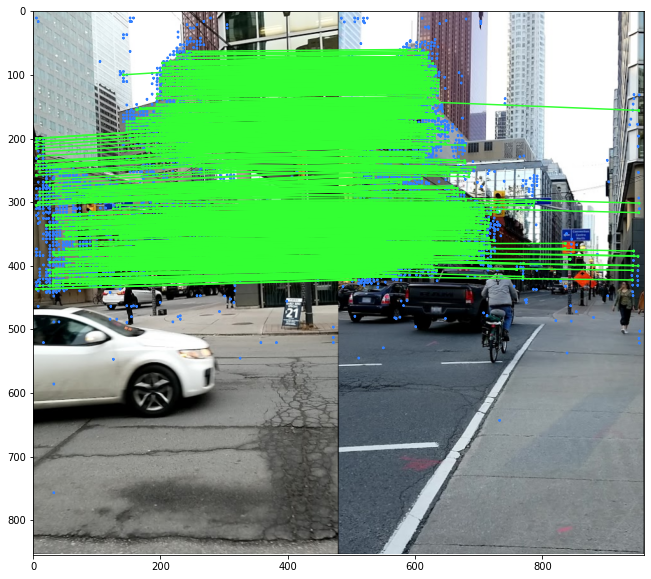

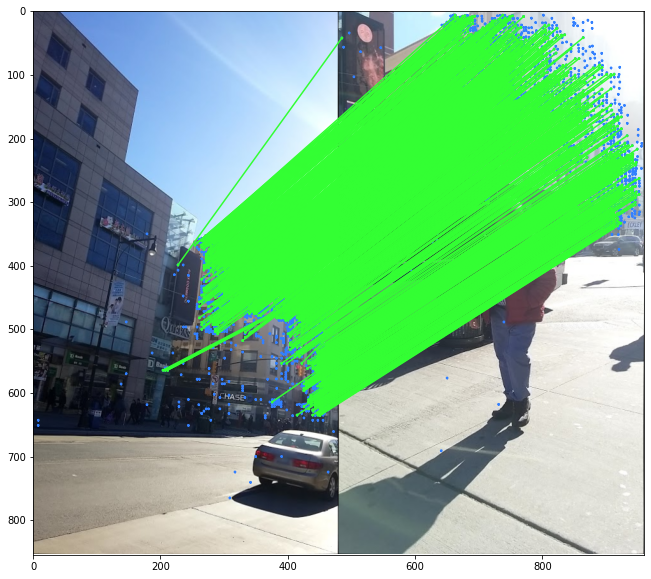

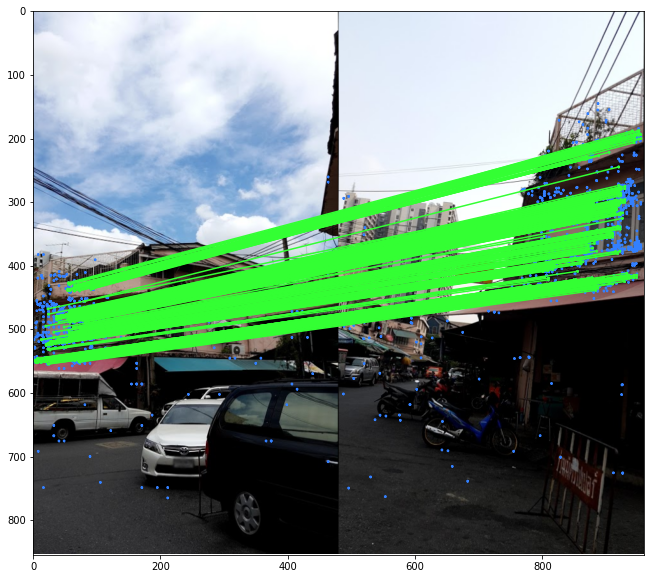

In [13]:
input_dir = "../input/image-matching-challenge-2022"
weight_dir = "../input/imc2022-pretrained-weights"
working_dir = "/root/.cache/torch/hub"
output_csv = "submission.csv"

seed_everything(0)
device = torch.device("cuda")
ext = "png"

#--------------------------------------------------------------------------------
# parameters
DKM_param = {
    "model": load_model_DKM(os.path.join(weight_dir, "dkm"), working_dir),
    "scale": 1.5,
    "sample_num": 10000,
    "nms_ret_points": 3000,
    "mkpts_num_thr": 300,
}
LoFTR_param = {
    "device": device,
    "model": load_model_LoFTR(os.path.join(weight_dir, "kornia-loftr", "loftr_outdoor.ckpt"), device),
    "img_size": 840,
    "nms_ret_points": 2000,
    "conf_min_thr": 0.4,
}
SE2LoFTR_param = {
    "device": device,
    "model": load_model_SE2LoFTR(os.path.join(weight_dir, "se2loftr", "4rot-big.ckpt"), device),
    "img_size": 840,
    "nms_ret_points": 2000,
    "conf_min_thr": 0.4,
}
SGM_param = {
    "model": load_model_SGMNet(os.path.join(weight_dir, "sgmnet", "sgm", "root")),
    "mkpts_num_thr": 5000,
}
findFMat_param = {
    "input_num": 3000,
    "ransacReprojThreshold": 0.15,
    "confidence": 0.9999,
    "maxIters": 20000,
}

params = {
    "LoFTR": LoFTR_param,
    "SE2LoFTR": SE2LoFTR_param,
    "DKM": DKM_param,
    "SGMNet": SGM_param,
    "findFMat": findFMat_param,
}
# parameters
#--------------------------------------------------------------------------------

df = pd.read_csv(os.path.join(input_dir, "test.csv"))
sample_ids = df["sample_id"].values
batch_ids = df["batch_id"].values
image_1_ids = df["image_1_id"].values
image_2_ids = df["image_2_id"].values

#-----------------
# pipeline process
queues_input, queues_output, len_wrap_funcs = prepare_multithreading(params)

sample_id_list = []
fund_matrix_list = []
idx = 0
while len(sample_id_list) < len(sample_ids):

    if idx >= len(sample_ids):
        args_1 = None
    else:
        args_1 = {
            "sample_id": sample_ids[idx],
            "image_dir": os.path.join(input_dir, "test_images", batch_ids[idx]),
            "image_1_id": image_1_ids[idx],
            "image_2_id": image_2_ids[idx],
            "ext": ext,
        }

    # start pipeline
    if idx == 0:
        args = {
            "args_1": args_1,
            "args_2": None,
        }
        init_inputs = [args] + [None]*(len_wrap_funcs - 1)  # [[], None, None, ...]
        inputs = init_inputs
    else:
        if outputs[-1] is None:
            args_2 = None
        else:
            args_2 = outputs[-1]["args_1"]

        args = {
            "args_1": args_1,
            "args_2": args_2,
        }
        inputs = [args] + outputs[:-1]

    outputs = loop_proc(queues_input, queues_output, inputs)
    _result = outputs[-1]
    if _result is None:
        result = None
    else:
        result = _result["args_2"]

    if result is not None:
        sample_id_list.append(result["sample_id"])
        fund_matrix_list.append(result["F"])

        # debug
        if len(sample_id_list) <= 3:
            print(f"{len(sample_id_list)} / {len(sample_ids)} : {result['sample_id']}")
            # draw mkpts
            batch_id = result["sample_id"].split(";")[1]
            image_pair = result["sample_id"].split(";")[2]
            image_1_id = image_pair.split("-")[0]
            image_2_id = image_pair.split("-")[1]
            draw_matching(
                os.path.join(input_dir, "test_images", batch_id),
                image_1_id, image_2_id, ext,
                result["mkpts1"], result["mkpts2"], result["inliers"])

    idx = idx + 1
# pipeline process
#-----------------

df = pd.DataFrame({"sample_id":sample_id_list, "fundamental_matrix":fund_matrix_list})
df.to_csv(output_csv, index=False)